# 基于ResNet50的红肉新鲜度检测

## 产出创意（作业一）
1. 选择**新鲜和过期红肉**数据集，完成**基于ResNet50的红肉新鲜度检测**项目。
2. 项目背景/意义：
食用过期肉类危害很大。肉类变质后微生物大量繁殖并产生代谢物，破坏人体的神经，导致肌肉僵硬麻痹，甚至引起急性中毒，出现恶心、呕吐、腹泻、腹痛、眩晕等症状，严重的还会昏迷，甚至会因为心力衰竭而死亡。如果长期食用，有毒物质会逐渐积累，从而造成慢性中毒。对大量肉品逐一进行化学物质检测耗时长、操作复杂，而通过计算机视觉的方法对肉品新鲜度进行检测，简化了检测流程，可以预防过期肉品流入市场引起消费者的健康问题。计算能力的提高、存储设备的发展，使得传统视觉技术中存在的问题逐渐得到改善或解决。我们可以将模型部署在相关的硬件上来实现落地应用。

3. 项目拟使用的方法：
检测肉品新鲜或过期属于一个二分类问题。使用ResNet50对新鲜和过期红肉数据集进行训练，检测时输入一张大小为224 x 224 x 3的图片，输出一个list类型的变量，其每个元素为输入图片的预测结果。预测结果为dict类型，key为该图片分类结果label，value为该label（肉品新鲜/过期）对应的概率。



## 数据处理（作业二）

### 解压数据集并查看目录结构

In [1]:
# 在同级目录下解压所挂载的数据集
! unzip -oq data/data84831/Meat_Quality_Assessment_Dataset.zip -d data/data84831
# 删除压缩包
! rm -r data/data84831/Meat_Quality_Assessment_Dataset.zip
! rm -r data/data84831/README.txt
! rm -r data/data84831/license.txt
# 查看数据集的目录结构
! tree data/data84831 -d


data/data84831
├── Fresh
└── Spoiled

2 directories


### 输入数据集路径，生成记录训练集和测试集的txt文件

In [2]:
# 输入数据集路径，生成记录训练集和测试集的txt文件
import os
import random

file_dir = "data"
data_list = []

if(os.path.exists('data/train.txt')):  # 判断有误文件
    os.remove('data/train.txt')  # 删除文件
if(os.path.exists('data/validation.txt')):
    os.remove('data/validation.txt')

for i in os.listdir(file_dir):
    class_id = 0
    path = os.path.join(file_dir, i)
    if os.path.isdir(path): 
        for j in os.listdir(path):
            class_id += 1
            for k in os.listdir(os.path.join(path, j)):
                s = os.path.join(path, j, k) + " " + str(class_id - 1)
                # print(s)
                data_list.append(s)

random.shuffle(data_list)
print(data_list[0])

data_len = len(data_list)
count = 0

for data in data_list:
    if count <= data_len*0.2:
        with open('data/validation.txt', 'a')as f:
            f.write(data + '\n')
            count += 1
    else:
        with open('data/train.txt', 'a')as tf:  # 80%写入训练集
            tf.write(data + '\n')
            count += 1


data/data84831/Fresh/test_20171017_073721D.jpg 0


### 语义分割数据集抽样可视化

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


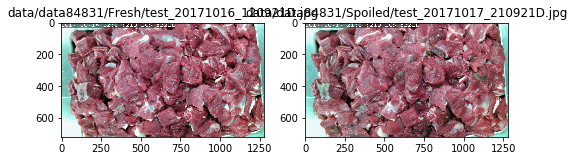

In [3]:
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 读取数据集中的图片
image_path_list = []
f = open(f'data/train.txt')
for line in f:
    temp = line.split(' ')
    image_path_list.append(temp[0])

test_list = ['data/data84831/Fresh/test_20171016_120921D.jpg', 'data/data84831/Spoiled/test_20171017_210921D.jpg']

plt.figure(figsize=(8, 8))
for i in range(len(test_list)):
    plt.subplot(len(test_list), 2, i + 1)
    plt.title(test_list[i])
    plt.imshow(cv2.imread(test_list[i])[:, :, ::-1])
    
plt.show()

### 计算图像数据整体均值和方差

In [4]:
import glob
import numpy as np

def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std


mean, std = get_mean_std(image_path_list)
print('mean:', mean)
print('std:', std)

Total images: 1516
mean: [0.44985259 0.41787232 0.57185417]
std: [0.206005   0.21695343 0.16529716]


### 数据集类的定义


In [5]:
import paddle
import numpy as np
import paddle.vision.transforms as T
from PIL import Image


class MeatDataset(paddle.io.Dataset):
    def __init__(self, mode='train'):
        """
        初始化函数
        """
        self.data = []
        with open(f'data/{mode}.txt') as f:
            for line in f.readlines():
                info = line.strip().split(' ')
                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])


    def __getitem__(self, index):
        """
        读取图片，对图片进行归一化处理，返回图片和 标签
        """
        image_file, label = self.data[index]  # 获取数据
        img = Image.open(image_file)  # 读取图片
        img = img.convert('RGB')
        img = img.resize((224, 224), Image.ANTIALIAS)  # 图片大小样式归一化
        img = np.array(img).astype('float32')  # 转换成数组类型浮点型32位
        img = img.transpose((2, 0, 1))     #读出来的图像是rgb,rgb,rbg..., 转置为 rrr...,ggg...,bbb...
        img = img / 255.0  # 数据缩放到0-1的范围
        # label = np.random.randint(low=0, high=self.num_classes, size=(1,))
        return img, np.array(label, dtype='int64')


    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

### 数据集类的测试


In [33]:
train_dataset = MeatDataset(mode='train')
val_dataset = MeatDataset(mode='validation')
print(len(train_dataset))
print(len(val_dataset))

image, label = train_dataset[0]
print(image.shape, label.shape)

for image, label in train_dataset:
    print(image.shape, label.shape)
    break

1516
380
(3, 224, 224) ()
(3, 224, 224) ()


In [7]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = True,
    drop_last = False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

0 [128, 3, 224, 224] [128]
1 [128, 3, 224, 224] [128]
2 [128, 3, 224, 224] [128]
3 [128, 3, 224, 224] [128]
4 [128, 3, 224, 224] [128]
5 [128, 3, 224, 224] [128]
6 [128, 3, 224, 224] [128]
7 [128, 3, 224, 224] [128]
8 [128, 3, 224, 224] [128]
9 [128, 3, 224, 224] [128]
10 [128, 3, 224, 224] [128]
11 [108, 3, 224, 224] [108]


## 选择模型并完成训练（作业三）

### 模型准备与可视化

In [30]:
# model prepare
from paddle.vision.models import resnet50
from paddle.metric import Accuracy

# build model and visualize
model = resnet50()
paddle.summary(model, (1,3, 224, 224))

model = paddle.Model(model)
optim = paddle.optimizer.Momentum(
    learning_rate=0.001, 
    momentum=0.9, 
    parameters=model.parameters(), 
    weight_decay=0.001)

model.prepare(
    optimizer=optim,
    loss=paddle.nn.CrossEntropyLoss(),
    metrics=Accuracy()
    )

--------------------------------------------------------------------------------
    Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-584       [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,408     
  BatchNorm2D-584    [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
      ReLU-188       [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
    MaxPool2D-12     [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
     Conv2D-586       [[1, 64, 56, 56]]     [1, 64, 56, 56]         4,096     
  BatchNorm2D-586     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
      ReLU-189        [[1, 256, 56, 56]]    [1, 256, 56, 56]          0       
     Conv2D-587       [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,864     
  BatchNorm2D-587     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
     Conv2D-588       [[1, 64, 56, 56]]     [1, 256, 56, 56]       16,384     
  BatchNorm2D-588     [[1, 256, 56, 56]]    [1, 25

### 模型训练

In [38]:
# train prepare
model.fit(
    train_dataset,
    epochs=10,
    batch_size=128,
    verbose=1
    )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 12/12 [==============================] - loss: 0.0676 - acc: 0.9512 - 3s/step        
Epoch 2/10
step 12/12 [==============================] - loss: 0.0562 - acc: 0.9631 - 3s/step        
Epoch 3/10
step 12/12 [==============================] - loss: 0.0760 - acc: 0.9828 - 3s/step        
Epoch 4/10
step 12/12 [==============================] - loss: 0.0238 - acc: 0.9815 - 3s/step        
Epoch 5/10
step 12/12 [==============================] - loss: 0.0316 - acc: 0.9881 - 3s/step        
Epoch 6/10
step 12/12 [==============================] - loss: 0.0496 - acc: 0.9914 - 3s/step        
Epoch 7/10
step 12/12 [==============================] - loss: 0.0080 - acc: 0.9947 - 3s/step        
Epoch 8/10
step 12/12 [==============================] - loss: 0.0249 - acc: 0.9954 - 3s/step        
Epoch 9/10
step 12/12 [==============================] - loss: 0.0385 - acc: 0.9960 - 3s/step        
Epoch 10/10
step 12/12 [==============================] - loss: 0.0110 - acc: 0.9980 - 3s/ste

### 测试模型

In [39]:
# test prepare
model.evaluate(val_dataset, batch_size=128, verbose=1)

Eval begin...
step 3/3 [==============================] - loss: 0.0151 - acc: 0.9974 - 3s/step
Eval samples: 380


{'loss': [0.01511826], 'acc': 0.9973684210526316}